<a href="https://colab.research.google.com/github/stoiver/anuga-clinic-2018/blob/master/notebooks/notebook5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSDMS ANUGA Clinic 2018

## Notebook 5: Monai Valley Tsunami runup 

Validation of the AnuGA implementation of the shallow water wave equation.
This script sets up Okushiri Island benchmark as published at the

THE THIRD INTERNATIONAL WORKSHOP ON LONG-WAVE RUNUP MODELS
June 17-18 2004

Wrigley Marine Science Center
Catalina Island, California
http://www.cee.cornell.edu/longwave/


The validation data was downloaded and made available in this directory
for convenience but the original data is available at
http://www.cee.cornell.edu/longwave/index.cfm?page=benchmark&problem=2
where a detailed description of the problem is also available.


### Installation

These notebooks have been designed to run in the google `colaboratory` environment, which provides a jupyter notebook environment running on a virtual machine on the cloud. To use this environment you need a google account so that your notebook can be saved on google drive. 

To start interacting with the notebook follow the 
`View in Colaboratory` link above. 

## Setup Environment

If on github, first follow the link `View in Colaboratory' to start running on google's colab environment. Then ....

Run the following cell to install the dependencies and some extra code for visualising on Colaboratory.

Wait until you see the comment *(5) Ready to go* before proceeding to subsequent commands. 

The install should take less than a minute (and quicker if you have already run this earlier).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
  # On colab we can install all the packages we need via the notebook
  #
  # First download the clinic repository
  import os
  os.chdir('/content')
  !git clone https://github.com/stoiver/anuga-clinic-2018.git

  # Now install environment using tool
  !/bin/bash /content/anuga-clinic-2018/anuga_tools/install_anuga_colab.sh
 
except:
  pass

# Make inline animate code available
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()

import sys
sys.path.append(os.path.join(workbookDir,"anuga-clinic-2018"))

Cloning into 'anuga-clinic-2018'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 563 (delta 6), reused 0 (delta 0), pack-reused 551
Receiving objects: 100% (563/563), 8.50 MiB | 12.72 MiB/s, done.
Resolving deltas: 100% (258/258), done.
(1) Install netcdf nose via pip
(2) Install gdal via apt-get
(3) Download anuga_core github repository
(4) Install anuga
(5) Ready to go


### Import ANUGA and Tools

Once `anuga` and `anuga_clinic-2018` have been installed we can now `import` our standard libraries.

In [0]:
%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

import anuga
import anuga_tools.animate as animate

## The Code 

This code is taken from `anuga_core/validation_tests/experimental_data/okishuri/run_okishuri.py`.


In [0]:
# Given boundary wave
boundary_filename = 'Benchmark_2_input.tms'

# Observed timeseries
validation_filename = 'output_ch5-7-9.txt'

# Digital Elevation Model
bathymetry_filename_stem = 'Benchmark_2_Bathymetry'
bathymetry_filename = bathymetry_filename_stem + '.pts'

# Triangular mesh
mesh_filename = 'Benchmark_2.msh'

# Model output
output_filename = 'okushiri_auto_validation.sww'

### Parameters to Setup Domain



Figure files for each frame will be stored in _plot


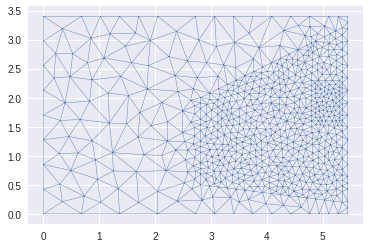

In [16]:
base_resolution = 0.1


# Basic geometry and bounding polygon
xleft   = 0
xright  = 5.448
ybottom = 0
ytop    = 3.402

point_sw = [xleft, ybottom]
point_se = [xright, ybottom]
point_nw = [xleft, ytop]    
point_ne = [xright, ytop]

bounding_polygon = [point_se,
                    point_ne,
                    point_nw,
                    point_sw]


# Localised refined area for gulleys
xl = 4.8; xr = 5.3; yb = 1.6; yt = 2.3
p0 = [xl, yb]
p1 = [xr, yb]
p2 = [xr, yt]
p3 = [xl, yt]

gulleys = [p0, p1, p2, p3]



# Island area and drawdown region
island_0 = [xleft + 2*(xright-xleft)/3+1.2, ytop-0.5]
island_1 = [xleft + 2*(xright-xleft)/3+0.5, ybottom + 2*(ytop-ybottom)/3]
island_2 = [xleft + (xright-xleft)/2+0.4, ybottom + 2*(ytop-ybottom)/3-0.3]
island_3 = [xleft + (xright-xleft)/2+0.4, ybottom + (ytop-ybottom)/3+0.3]
island_4 = [xleft + 2*(xright-xleft)/3+0.4, ybottom + (ytop-ybottom)/3-0.3]
island_5 = [xleft + 2*(xright-xleft)/3+1.2, ybottom+0.8]
island_6 = [xl, yb]  
island_7 = [xl, yt]

island = [island_0, island_1, island_2,
          island_3, island_4, island_5,
          island_6, island_7]



# Region spanning half right hand side of domain just inside boundary
rhs_nw = [xleft + (xright-xleft)/3+1, ytop-1.4]
rhs_sw = [xleft + (xright-xleft)/3+1, ybottom+0.5]
rhs_se = [xright-0.1, ybottom+0.2]
rhs_ne = [xright-0.1, ytop-0.2]        

rhs_region = [rhs_nw, rhs_ne, rhs_se, rhs_sw]


# Interior regions and creation of mesh
interior_regions = [[rhs_region, 0.1*base_resolution],
                    [island, 0.1*base_resolution],
                    [gulleys, 0.05*base_resolution]]    


domain = anuga.create_domain_from_regions(bounding_polygon,
                                 boundary_tags={'wall': [0, 1, 3],
                                                'wave': [2]},     
                                 maximum_triangle_area=base_resolution,
                                 interior_regions=interior_regions,
                                 use_cache=False,
                                 verbose=False)

dplotter = animate.Domain_plotter(domain)  
plt.triplot(dplotter.triang, linewidth = 0.4);

Create Mesh

In [0]:


#-------------------------
# Initial Conditions
#-------------------------
domain.set_quantity('friction', 0.0025)
domain.set_quantity('stage', 0.0)

domain.set_quantity('elevation',
                    filename=project.bathymetry_filename,
                    alpha=0.001,                    
                    verbose=verbose)

#-------------------------
# Set simulation parameters
#-------------------------
domain.set_name(project.output_filename)  # Name of output sww file 
domain.set_minimum_storable_height(0.001) # Don't store w-z < 0.001m


#-------------------------
# Boundary Conditions
#-------------------------

# Create boundary function from timeseries provided in file
wave_function = anuga.file_function(project.boundary_filename,
                         domain, verbose=verbose)

# Create and assign boundary objects
Bts = anuga.Transmissive_n_momentum_zero_t_momentum_set_stage_boundary(domain, wave_function)
Br = anuga.Reflective_boundary(domain)
domain.set_boundary({'wave': Bts, 'wall': Br})

#-------------------------
# Evolve through time
#-------------------------
import time
t0 = time.time()

for t in domain.evolve(yieldstep = 0.05, finaltime = 25.0):
    domain.write_time()



print 'That took %.2f seconds' %(time.time()-t0)


### RiverWall Setup and Utility Procedure

We will be setting up a `riverwall` which implicitly has an associated polyline. Setup a procedure to pull out this polyline so that it can be used in the construction of the `domain`.



In [0]:
riverWall = { 'centralWall':
                           [ [wallLoc, 0.0, wallHeight],
                             [wallLoc, 100.0, wallHeight]] 
                        }

riverWall_Par = {'centralWall':{'Qfactor':1.0}}

def toPolyline(riverWall):
  return [np.array(riverWall.values()[0])[:,0:2].tolist()]

### Setup Pump geometry

First setup the inlet and outlet polygonal regions of the pump. 

In [0]:
end_point0 = [49.0,50.0]
end_point1 = [51.0,50.0]

end_points = [end_point0, end_point1]

inlet1_poly = [[[end_point0[0]-10, 45.0],[end_point0[0]-10,55],
                [end_point0[0],55],[end_point0[0],45],[end_point0[0]-10, 45.0]]]
              
inlet2_poly = [[[end_point1[0], 45.0],[end_point1[0],55],
                [end_point1[0]+10,55],[end_point1[0]+10,45],[end_point1[0], 45.0]]]
              

### Create and Setup Domain

Create  a domain with a breakline down the middle (where the riverWall will occur) and two polygonal regions where the inlet and oulet polygons will sit. 

In [0]:
domain = anuga.create_domain_from_regions(boundaryPolygon, 
                           boundary_tags={'left': [0],
                                        'top': [1],
                                        'right': [2],
                                        'bottom': [3]},
                           maximum_triangle_area = 10.0,
                           minimum_triangle_angle = 28.0,
                           interior_regions =[ ], #[ [higherResPolygon, 1.*1.*0.5],
                                                  #  [midResPolygon, 3.0*3.0*0.5]],
                           breaklines=toPolyline(riverWall)+inlet1_poly+inlet2_poly,
                           regionPtArea=regionPtAreas,
                           use_cache=False,
                           verbose=False
                           )


#domain.set_flow_algorithm('DE1')
domain.set_name('run_pump')
domain.set_store_vertices_uniquely(True)

d_plotter = animate.Domain_plotter(domain)

### Setup Initial Conditions

We will have a slight slope down towards the right, with water height `InitialOceanStage` on the  right, and `InitialLandStage` on the left.

In [0]:
def topography(x,y):
    return -x/150. 

def stagefun(x,y):
    stg = InitialOceanStage*(x>=wallLoc) + InitialLandStage*(x<wallLoc)
    return stg 


# NOTE: Setting quantities at centroids is important for exactness of tests
domain.set_quantity('elevation',topography,location='centroids')     
domain.set_quantity('stage', stagefun,location='centroids')    

### Setup RiverWall 

From the `riverWall` polyline and elevation data create a riverWall  `operator`. Looking back at the definition of `riverWall` we see that this will create a wall of height `wallHeight` down the middle of the domain. 

In [0]:
domain.riverwallData.create_riverwalls(riverWall,riverWall_Par,verbose=False) 

### Boundary conditions

Simple reflective BC all around


In [0]:
Br = anuga.Reflective_boundary(domain)
domain.set_boundary({'left': Br, 'right': Br, 'top': Br, 'bottom':Br})

### Setup pump Operator

(1) First setup the pump characteristics

(2) Then locate and create the pump using the operator

In [0]:
pump_function = anuga.pumping_station_function(
            domain=domain,
            pump_capacity=100.0,
            hw_to_start_pumping=0.0,
            hw_to_stop_pumping=-1.0,
            initial_pump_rate=100.0, 
            pump_rate_of_increase = 50.0, 
            pump_rate_of_decrease = 50.0, 
            verbose=True)


end_points = [[49.0,50.0],[51.0,50.0]]
pump = anuga.Internal_boundary_operator(domain, pump_function,
                                        width = 10.0,
                                        height = 1.0,
                                        apron = 10.0,
                                        end_points=end_points,
                                        verbose=True)


### Evolve

Monitor the amount of water on each side of the wall. The sum should remain constant, and the change should be match the pump capacity.

In [0]:
region1 = anuga.Region(domain, polygon=[[0.0,0.0], [50.0,0.0], [50.0, 100.0], [0.0,100.0]])
region2 = anuga.Region(domain, polygon=[[50.0,0.0], [100.0,0.0], [100.0, 100.0], [50.0,100.0]])

for t in domain.evolve(yieldstep=2, duration=60):
    domain.print_timestepping_statistics()
    stage = domain.get_quantity('stage')
    elev  = domain.get_quantity('elevation')
    height = stage - elev
    
    d_plotter.plot_depth_frame()

    print anuga.indent + 'Integral1 = ', height.get_integral(region=region1)
    print anuga.indent + 'Integral2 = ', height.get_integral(region=region2)
    print anuga.indent + 'Total Integral = ', height.get_integral()
    #pump.print_timestepping_statistics()

## Visualise Flow

Let's open up the `swwfile` and look at the evolution of the `depth` the `stage` and the `elev`.

In [0]:
# Create a wrapper for contents of sww file
swwfile = 'run_pump.sww'
splotter = animate.SWW_plotter(swwfile);

plt.triplot(splotter.triang, linewidth = 0.4);

In [0]:
# plot stage
splotter.triang.set_mask(None)
for i,time in enumerate(splotter.time):
  print time
  splotter.save_stage_frame(i)
  
splotter.make_stage_animation()

## Animation

We ca use the `FuncAnimation' function to animate a sequence of timeslices (in this case `stage`)




In [0]:
def update_frame(i):
  ax.clear()
  artist = ax.tripcolor(splotter.triang, 
              facecolors = splotter.stage[i], 
              edgecolors='k', 
              cmap='Spectral',
              vmax = 6.0,
              vmin = 2.0) 
  ax.set_title('Stage (time %05.2f)' % splotter.time[i],loc='right')
  fig.colorbar(artist, cax=cax)
  

  
fig = plt.figure();
ax = plt.gca();
cax = fig.add_axes([0.91, 0.125, 0.03, 0.75])

# increase step to skip frames; increase interval to increase movie speed
step = 2
anim = animation.FuncAnimation(fig, update_frame, frames=len(splotter.depth)/step, interval=200);


plt.close()

anim


###  3D Surface Plots

We can use the mpl module to produce some 3D plots. We need to create vertex values given the centroid values.

In [0]:

X = np.vstack((splotter.xc, splotter.yc)).transpose()
E = splotter.elev

splotter.nodes = np.vstack((splotter.x,splotter.y)).transpose()
import scipy

stage_v = []
for i,S in enumerate(splotter.stage):
  #print i, S.shape, X.shape
  Interp = scipy.interpolate.NearestNDInterpolator(X,S)
  stage_v.append(Interp(splotter.nodes))
  
stage_v = np.array(stage_v)

Interp = scipy.interpolate.NearestNDInterpolator(X,E)
elev_v = Interp(splotter.nodes)





from matplotlib.animation import FuncAnimation
#from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure();
#fig, ax = plt.subplots()
ax = plt.gca(projection='3d');

def update_image(i):
  ax.clear()
  ax.plot_trisurf(splotter.triang, elev_v, color='navajowhite', edgecolors='none', antialiased=False, shade=True);
  ax.plot_trisurf(splotter.triang, stage_v[i*step], color='dodgerblue', edgecolors='none', alpha=1.0, linewidth=0, antialiased=False, shade=True);
  ax.set_zlim(elev_v.min(), np.max([stage_v.max(), elev_v.max()]));
    

# increase step to skip frames; increase interval to increase movie speed
step = 4
anim = FuncAnimation(fig, update_image, frames=len(splotter.depth)/step, interval=200);

plt.close()

anim